# Fraud Detection

Data source: https://www.kaggle.com/dalpozz/creditcardfraud

Reference: <br>
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py <br>
http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html <br>
https://www.wikiwand.com/en/Receiver_operating_characteristic <br>
           https://www.kaggle.com/joparga3/d/dalpozz/creditcardfraud/in-depth-skewed-data-classif-93-recall-acc-now <br>
           https://www.kaggle.com/arathee2/d/dalpozz/creditcardfraud/achieving-100-accuracy

***This project is for testing different models and methods that are used to tackle the highly skewed data or imbalance data (eg. the majority of the data record comes from a single class). Specifically, the methods concerning sampling, classifiers and the criterial like ROC-AUC and precision recall.
In addition, I would like to some techniques of unsupervised learning in this project.
In Kaggle kernels, some models have been built with simple steps which achieves high accuracy (also high recall), I will not try to build any model here.***


# Modules

In [228]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools as itr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import metrics
from sklearn.manifold import TSNE

pd.options.display.max_columns = 999
%matplotlib inline

# Read data

In [40]:
df = pd.read_csv("./data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [47]:
df.shape

(284807, 30)

# Class distribution

class 0 account for 0.998273
class 1 account for 0.001727


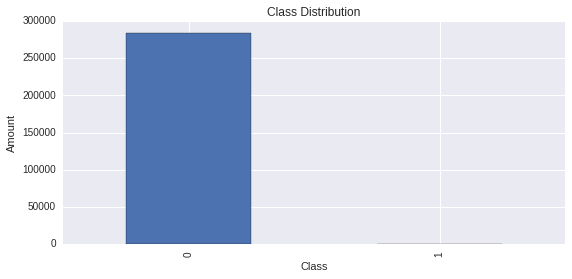

In [41]:
plt.figure(figsize=(9,4))

class_count = df.Class.value_counts()
class_count.plot("bar");
plt.title("Class Distribution");
plt.xlabel("Class");
plt.ylabel("Amount");
plt.xticks(rotation='vertical')
print("class 0 account for %f" % (class_count[0]/sum(class_count)))
print("class 1 account for %f" % (class_count[1]/sum(class_count)))

We could see extremely unbalance of the class in the data

The majority class account for over 99.8% of the total data. Thus, even if we predict all the data as class 0, we will get an extremely high accuracy. However, this will let us miss the important class 1, which will be of great concern for the data scientists.

***What can we do?***
Here is a great blog for reference: <br>
http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

Typically, the ways to tackle this problem are:
  1. Collecting more data (Not feasible here)
  2. Try changing your performance metric:
     ***Confusion Matrix, Precision-Recall, F1, Kappa, ROC-AUC***
  3. Try resampling the data:
     ***Oversampling or Undersampling***

Next, we will test the effect of resampling by building a simple ***logistic regression *** model.

# Input preparation

### 1.Check distribution

In [42]:
df.describe().ix[["mean","std"],"V1":"V28"]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
mean,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,...,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01


In [43]:
df.describe().ix[["mean","std"],"Amount"]

mean     88.349619
std     250.120109
Name: Amount, dtype: float64

The data contains features: Time, Amount, Class and V1 to V28.
The feature ***V1 to V28*** will be used as our predictors. We will normalize the Amount before continuing

### 2. Normalization

In [44]:
norm = StandardScaler()
df.ix[:,"Amount"] = norm.fit_transform(df.ix[:,"Amount"])

/home/peiran/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/peiran/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


### 3. Drop Time

In [45]:
df = df.drop(["Time"],axis = 1)

In [46]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


# Resampling

### Undersampling

In our situation, we have over 280k rows of data where a ***Undersampling*** method is a good choice.

***Split data to X and y***

In [107]:
X = df.ix[:,df.columns != "Class"]
y = df.ix[:,df.columns == "Class"].values.reshape(-1,)

***Create Under-sampling data***

In [109]:
# split to normal and fraud
df_normal = df.ix[df["Class"] == 0,:]
df_fraud = df.ix[df["Class"] == 1,:]

# get df_normal index
df_fraud_size = df_fraud.shape[0]
df_normal_index = df_normal.index

# sample from normal index
df_normal_us_index = np.random.choice(df_normal_index, df_fraud_size, replace=False)

# get df_normal_us
df_normal_us = df_normal.ix[df_normal_us_index,:]

# get undersample data
df_us = pd.concat([df_fraud, df_normal_us],axis = 0)

# split to X and y
X_us = df_us.ix[:,df.columns != "Class"]
y_us = df_us.ix[:,df.columns == "Class"].values.reshape(-1,)

In [77]:
df_us.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.353229,1
623,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.761758,1
4920,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,0.606031,1
6108,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,-0.117342,1
6329,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,-0.349231,1


In [78]:
print("Ratio of normal is: ", sum(df_us["Class"]==0)/df_us.shape[0])
print("Ratio of fraud is: ", sum(df_us["Class"]==1)/df_us.shape[0])

Ratio of normal is:  0.5
Ratio of fraud is:  0.5


***Create train and test data for original data and under sampling data***

In [158]:
# split of original data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# split of undersampling data
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, test_size=0.3, random_state=0)

# Logistic Regression Test

### 1. Undersampling data

The strategy we use when building the model is to use cross-validation to evaluate the model and select the best model to be applied on the test data.

In [159]:
# build logistic regression on training data
skf = StratifiedKFold(n_splits=10, shuffle=True)

# parameters
C_param = [0.01,0.1,1,10,100]
penalty_param = ["l1","l2"]

params_range = [(c,p) for c in C_param for p in penalty_param]

print("Grid Search")
print("*****************************************************")
# Kfold cross validation to select the C_param
for c_p, p_p in params_range:
    
    results = []
    for train_index,test_index in skf.split(X_train_us,y_train_us):
        
        # train test split
        X_train_us_cv,X_test_us_cv = X_train_us.iloc[train_index,:],X_train_us.iloc[test_index,:]
        y_train_us_cv,y_test_us_cv = y_train_us[train_index],y_train_us[test_index]
        
        # initalize a logistic model
        lg = LogisticRegression(penalty=p_p, C=c_p, n_jobs=-1)
        
        # train the model on train data
        lg.fit(X_train_us_cv, y_train_us_cv)
        
        # make predictions
        y_pred_us_cv = lg.predict(X_test_us_cv)
        
        # calculate recall score
        recall_acc = metrics.recall_score(y_test_us_cv,y_pred_us_cv)
        results.append(recall_acc)
        
    print("The parameters penalty = %s and C = %f gives the best recall score of %f" 
              % (p_p,c_p,sum(results)/len(results)))

Grid Search
*****************************************************
The parameters penalty = l1 and C = 0.010000 gives the best recall score of 0.956639
The parameters penalty = l2 and C = 0.010000 gives the best recall score of 0.907395
The parameters penalty = l1 and C = 0.100000 gives the best recall score of 0.889832
The parameters penalty = l2 and C = 0.100000 gives the best recall score of 0.898655
The parameters penalty = l1 and C = 1.000000 gives the best recall score of 0.904706
The parameters penalty = l2 and C = 1.000000 gives the best recall score of 0.906975
The parameters penalty = l1 and C = 10.000000 gives the best recall score of 0.907479
The parameters penalty = l2 and C = 10.000000 gives the best recall score of 0.913361
The parameters penalty = l1 and C = 100.000000 gives the best recall score of 0.913445
The parameters penalty = l2 and C = 100.000000 gives the best recall score of 0.904538


So the best parameter combination is ***penalty = l1 and C = 0.01*** <br>
The best recall score is ***0.956639***

What happend in the confusion matrix?

In [163]:
# reproduce the result on train data
lg = LogisticRegression(penalty="l1", C=0.01, n_jobs=-1)
lg.fit(X_train_us, y_train_us)
y_pred_us = lg.predict(X_test_us)

# get recall score on test data
metrics.recall_score(y_test_us,y_pred_us)

0.94557823129251706

We get a score of 0.945578 on the test data from the best model in the cross validation

code adjusted from sklearn doc http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

[[133  16]
 [  8 139]]


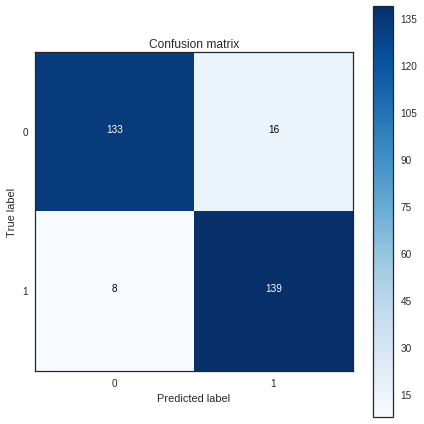

Recall Score is 0.945578231293


In [187]:
sns.set_style("white")

# plot confusion matrix
def plot_confusion_matrix(cm, classes,title,cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itr.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_us, y_pred_us)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=[0,1],title='Confusion matrix')

plt.show()

print("Recall Score is", metrics.recall_score(y_test_us,y_pred_us))

***Recall is defined as: TP/(TP + FN) = 139/(139+8) = 0.945578231293***

***The performance is ideal considering that we have a balanced data.
We can also evlauate its performance on the original data set and check the recall***

In [188]:
# reproduce the result on train data
lg = LogisticRegression(penalty="l1", C=0.01, n_jobs=-1)
lg.fit(X_train_us, y_train_us)
y_pred = lg.predict(X_test)

# get recall score on test data
metrics.recall_score(y_test,y_pred)

0.93877551020408168

[[74854 10442]
 [    9   138]]


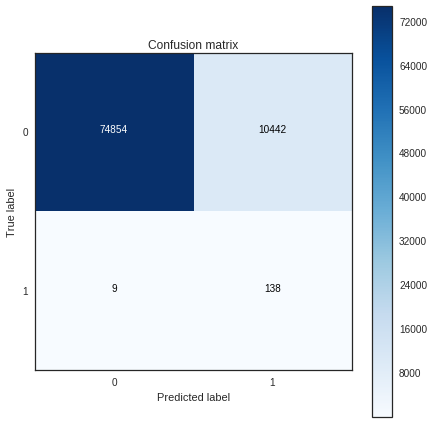

Recall Score is 0.938775510204


In [189]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=[0,1],title='Confusion matrix')

plt.show()

print("Recall Score is", metrics.recall_score(y_test,y_pred))

The logistic regression gives a recall of ***0.93878***, which is desirable.

***Next, we can compare the performance of logistic regression on the original data (imbalanced) with the model performance above***

#### original imbalance data

In [191]:
# build logistic regression on training data
skf = StratifiedKFold(n_splits=10, shuffle=True)

# parameters
C_param = [0.01,0.1,1,10,100]
penalty_param = ["l1","l2"]

params_range = [(c,p) for c in C_param for p in penalty_param]

print("Grid Search")
print("*****************************************************")
# Kfold cross validation to select the C_param
for c_p, p_p in params_range:
    
    results = []
    for train_index,test_index in skf.split(X_train,y_train):
        
        # train test split
        X_train_cv,X_test_cv = X_train.iloc[train_index,:],X_train.iloc[test_index,:]
        y_train_cv,y_test_cv = y_train[train_index],y_train[test_index]
        
        # initalize a logistic model
        lg = LogisticRegression(penalty=p_p, C=c_p, n_jobs=-1)
        
        # train the model on train data
        lg.fit(X_train_cv, y_train_cv)
        
        # make predictions
        y_pred_cv = lg.predict(X_test_cv)
        
        # calculate recall score
        recall_acc = metrics.recall_score(y_test_cv,y_pred_cv)
        results.append(recall_acc)
        
    print("The parameters penalty = %s and C = %f gives the best recall score of %f" 
              % (p_p,c_p,sum(results)/len(results)))

Grid Search
*****************************************************
The parameters penalty = l1 and C = 0.010000 gives the best recall score of 0.565714
The parameters penalty = l2 and C = 0.010000 gives the best recall score of 0.588487
The parameters penalty = l1 and C = 0.100000 gives the best recall score of 0.606471
The parameters penalty = l2 and C = 0.100000 gives the best recall score of 0.591681
The parameters penalty = l1 and C = 1.000000 gives the best recall score of 0.617395
The parameters penalty = l2 and C = 1.000000 gives the best recall score of 0.617563
The parameters penalty = l1 and C = 10.000000 gives the best recall score of 0.622941
The parameters penalty = l2 and C = 10.000000 gives the best recall score of 0.608739
The parameters penalty = l1 and C = 100.000000 gives the best recall score of 0.611765
The parameters penalty = l2 and C = 100.000000 gives the best recall score of 0.620252


The logistic regression performs not well when the data is highly skewed. <br>
We could check the confusion matrix agian with the best parameter.

In [192]:
# reproduce the result on train data
lg = LogisticRegression(penalty="l1", C=10, n_jobs=-1)
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)

# get recall score on test data
metrics.recall_score(y_test,y_pred)

0.61904761904761907

[[85284    12]
 [   56    91]]


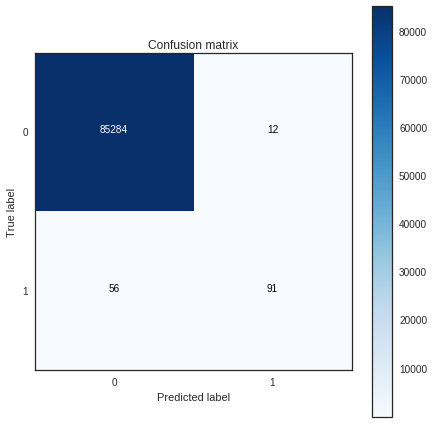

Recall Score is 0.619047619048


In [193]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=[0,1],title='Confusion matrix')

plt.show()

print("Recall Score is", metrics.recall_score(y_test,y_pred))

We can see that the logistic regression identifies most of the Negative samples but missed nealy half of the Positive samples, which means that it intend to predict all the sample to be the Negative class. The internal difference between may not be detected.

#### ROC curve and precision-recall curve

***The confusion matrix can only tell us the results, but hide the internal structure of the logistic regression.  We have to look at the difference between the two models based on the precision-recall curve and the ROC curve.***

1.ROC (from scratch)

In [221]:
def get_roc(y_test, y_pred_prob):
    TPR_series = []
    FPR_series = []
    for thresh in np.arange(0,1.01,0.005):
        y_pred = (np.array(y_pred_prob) > thresh) * 1
        cm = metrics.confusion_matrix(y_test, y_pred)
        TP = cm[1,1]
        FN = cm[1,0]
        TN = cm[0,0]
        FP = cm[0,1]

        TPR = TP/(TP+FN)
        FPR = FP/(FP+TN)
        TPR_series.append(TPR)
        FPR_series.append(FPR)
    
    TPR_series = np.array(TPR_series)
    FPR_series = np.array(FPR_series)
    
    return (TPR_series, FPR_series)

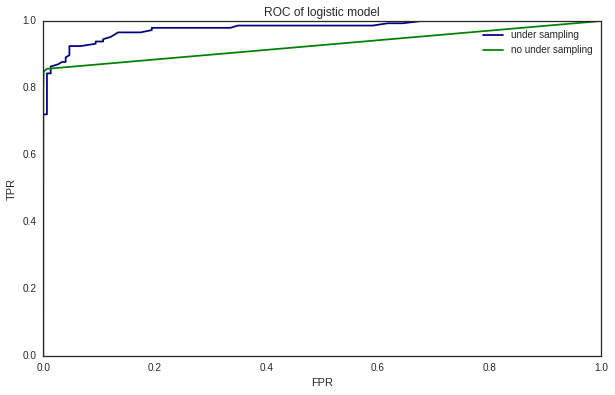

In [224]:
# get tpr and fpr of undersampling data
lg_us = LogisticRegression(penalty="l1", C=0.01, n_jobs=-1)
lg_us.fit(X_train_us, y_train_us)
y_pred_prob_us = lg_us.predict_proba(X_test_us)[:,1]
tpr_us, fpr_us = get_roc(y_test_us, y_pred_prob_us)

# get tpr and fpr of original data
lg = LogisticRegression(penalty="l1", C=10, n_jobs=-1)
lg.fit(X_train, y_train)
y_pred_prob = lg.predict_proba(X_test)[:,1]
tpr, fpr = get_roc(y_test, y_pred_prob)

# plot
plt.figure(figsize = (10,6));
plt.plot(fpr_us, tpr_us, color='navy',
         label='under sampling');

plt.plot(fpr, tpr, color='green',
         label='no under sampling');

plt.legend();
plt.xlabel("FPR");
plt.ylabel("TPR");
plt.title("ROC of logistic model");

***We can see that the undersampling data improve the performance of the logistic regression. The blue line is generally above the green line***

We also notice that the green line has a linear trend, which means that the logistic model has trouble to detect the fraud (positive samples)

2.Precision-Recall

In [ ]:
# TODO

### 2. Anomaly detection

#### Use t-SNE to visualize the data in 2D

To detect the inner structure of the data, I will use t-SNE method for dimention reduction and highlight the class of each transformed point in the 2D graph

To avoid memory error when using the whole data set, we only sample part of the data


In [258]:
tsne_data = df.sample(n = 10000, random_state=0)

X_tsne = tsne_data.ix[:,tsne_data.columns != "Class"]
y_tsne = tsne_data.ix[:,tsne_data.columns == "Class"].values.reshape(-1,)

# plot the 2D graph with different perplexity in the t-SNE
ts = TSNE(n_components=2, random_state=0, perplexity=20,verbose=2)
X_2d = ts.fit_transform(X_tsne)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.036789
[t-SNE] Iteration 25: error = 1.7449288, gradient norm = 0.0011120
[t-SNE] Iteration 50: error = 1.7425876, gradient norm = 0.0087424
[t-SNE] Iteration 75: error = 1.6663098, gradient norm = 0.0030605
[t-SNE] Iteration

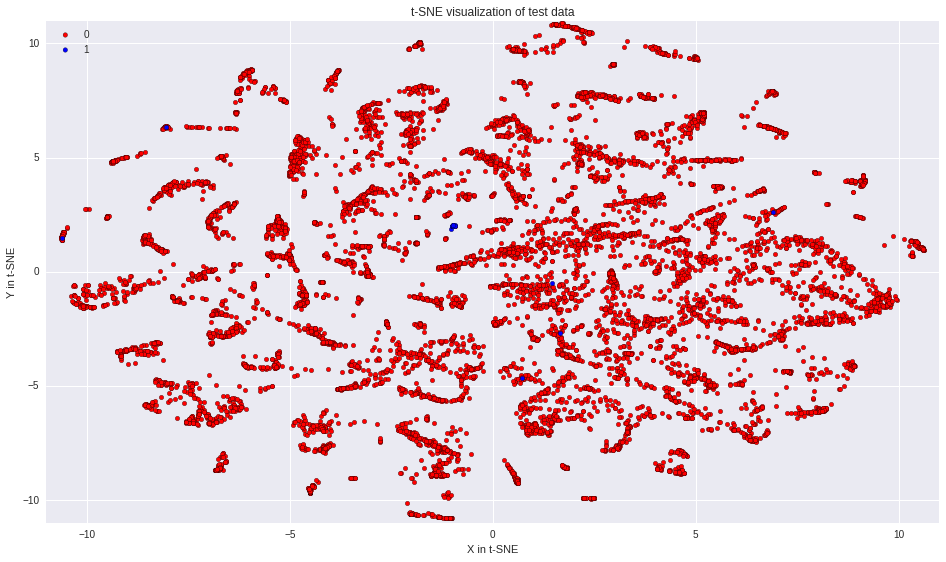

In [259]:
sns.set_style("darkgrid")
color_map = {0:'red', 1:'blue'}
plt.figure(figsize=(16,9))
for idx, cl in enumerate(np.unique(y_tsne)):
    plt.scatter(x = X_2d[y_tsne==cl,0], 
                y = X_2d[y_tsne==cl,1], 
                c = color_map[idx], 
                label = cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.xlim([-11,11])
plt.ylim([-11,11])
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()

From the projection of t-SNE, we can see that the fraud samples are generally far from the normal samples, meaning a model could be build to achieve a desirable prediction result.